In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [0]:
from google.colab import files
files = files.upload()

Saving model (1).h5 to model (1).h5


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Save Keras Model or weights on google drive

# create on Colab directory
#model.save('model.h5')    
model_file = drive.CreateFile({'title' : 'model.h5'})
model_file.SetContentFile('model.h5')
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1dhqnIzMnbJwY8Xy3wOXaKEN_i9XOLQmt'})

In [0]:
!pip install git+https://github.com/qubvel/classification_models.git
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-fdo75ryv
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-fdo75ryv
  Running command git submodule update --init --recursive -q
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-cp36-none-any.whl size=19950 sha256=185ad0961aeecde300d7092ac6a332347a5308218fc1ee00ec2c6ac06f1c65c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-5lsp5u4i/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-703ljnkx
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-703ljnkx
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=0024beaa03278a8bb284f02d01a4aed6916a50dd19fd572fcb9bea246ad4ddcc
  Stored in directory: /tmp/p

In [0]:
%tensorflow_version 1.x

import os
import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.applications import ResNet50
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator

from keras_contrib.callbacks import CyclicLR


Using TensorFlow backend.


In [0]:
# parameters
BATCH_SIZE =  32#@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.005 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS =  10#@param {type:"integer"}
DATA_AUGMENTATION = True #@param {type: "boolean"}
PIXEL_LEVEL = False #@param {type: "boolean"}

In [0]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [0]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)


cols = ['gender', 'imagequality', 'age', 'weight', 'carryingbag', 'footwear', 'emotion', 'bodypose']
for c in cols:
  merged = [i for i in one_hot_df.columns if i.startswith(c)]
  one_hot_df[c] = one_hot_df[merged].values.tolist()

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 36), (2036, 36))

In [0]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose
4642,resized/4643.jpg,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,"[1, 0]","[0, 0, 1]","[0, 0, 1, 0, 0]","[0, 1, 0, 0]","[0, 0, 1]","[1, 0, 0]","[1, 0, 0, 0]","[0, 1, 0]"
1710,resized/1711.jpg,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,"[0, 1]","[1, 0, 0]","[1, 0, 0, 0, 0]","[1, 0, 0, 0]","[0, 0, 1]","[0, 0, 1]","[0, 0, 1, 0]","[1, 0, 0]"
10235,resized/10237.jpg,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,"[0, 1]","[0, 0, 1]","[0, 1, 0, 0, 0]","[1, 0, 0, 0]","[0, 0, 1]","[1, 0, 0]","[0, 0, 1, 0]","[0, 1, 0]"
8968,resized/8969.jpg,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,"[1, 0]","[0, 0, 1]","[0, 0, 1, 0, 0]","[1, 0, 0, 0]","[0, 1, 0]","[0, 0, 1]","[0, 0, 1, 0]","[0, 1, 0]"
12736,resized/12738.jpg,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0,"[0, 1]","[1, 0, 0]","[0, 1, 0, 0, 0]","[0, 0, 1, 0]","[0, 0, 1]","[1, 0, 0]","[0, 0, 1, 0]","[0, 1, 0]"


In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=BATCH_SIZE)
valid_gen = PersonDataGenerator(val_df, batch_size=BATCH_SIZE, shuffle=False)

In [0]:
# get number of output units from data
images, targets = next(iter(train_gen))
print(images.shape)
print(targets.keys())
num_units = { k.split("_output")[0]:v.shape[1]-1 for k, v in targets.items()}
num_units

(32, 224, 224, 3)
dict_keys(['gender_output', 'image_quality_output', 'age_output', 'weight_output', 'bag_output', 'pose_output', 'footwear_output', 'emotion_output'])


{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 5:
        lr *= 0.5e-3
    elif epoch > 10:
        lr *= 1e-3
    elif epoch > 15:
        lr *= 1e-2
    elif epoch > 20:
        lr *= 1e-1
    #lr = round(0.004 * 1/(1 + 0.319 * epoch), 10)
    print('Learning rate: ', lr)
    return lr

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
from classification_models.keras import Classifiers

ResNet18, preprocess_input = Classifiers.get('resnet18')

backbone = ResNet18(
    weights=None, 
    include_top=False, 
    input_tensor=Input(shape=(256, 256, 3))
)

neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(64, activation="relu")(neck)
    neck = Dropout(0.3)(in_layer)
    neck = Dense(64, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)
model.summary()

KeyboardInterrupt: ignored

In [0]:
# from google.colab import files
# files = files.upload()

In [0]:
from keras.models import load_model
model = load_model('model.h5')

In [0]:
losses = {
	"gender_output": "binary_crossentropy",
	"image_quality_output": "categorical_crossentropy",
	"age_output": "categorical_crossentropy",
	"weight_output": "categorical_crossentropy",
  "bag_output": "categorical_crossentropy",
  "footwear_output": "categorical_crossentropy",
  "pose_output": "categorical_crossentropy",
  "emotion_output": "categorical_crossentropy"
}
loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, 
                "age_output": 1.0, "weight_output": 1.0, 
                "bag_output": 1.0, "footwear_output": 1.0, 
                "pose_output": 1.0, "emotion_output": 1.0}
sgd = SGD(lr=LEARNING_RATE, momentum=MOMENTUM, nesterov=True) 
model.compile(
    optimizer=sgd,
    loss=losses, 
    loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [0]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = '%s_model.{epoch:03d}.h5' % 'resnet50'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

#lr_scheduler = CyclicLR(base_lr=0.001, max_lr=0.003, mode='triangular2')
def lr_schedule(epoch):
  return 0.0008
lr_scheduler = LearningRateScheduler(lr_schedule)

callbacks = [lr_scheduler]

In [0]:
# Run training, with or without data augmentation.
if not DATA_AUGMENTATION:
    print('Not using data augmentation.')
    history = model.fit_generator(
              generator=train_gen,
              validation_data=valid_gen,
              batch_size=32,
              epochs=50,
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False,
        preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=PIXEL_LEVEL))
    
    valid_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        horizontal_flip=True,
        vertical_flip=False
    )
    
    train_gen = train_datagen.flow_from_dataframe(
                          dataframe=train_df, 
                          batch_size=BATCH_SIZE,
                          x_col='image_path',
                          y_col=['gender', 'imagequality', 'age', 'weight', 'carryingbag', 'footwear', 'bodypose', 'emotion'],
                          shuffle=True,
                          class_mode="multi_output")

    valid_gen = valid_datagen.flow_from_dataframe(
                          dataframe=val_df,
                          batch_size=BATCH_SIZE,
                          x_col='image_path',
                          y_col=['gender', 'imagequality', 'age', 'weight', 'carryingbag', 'footwear', 'bodypose', 'emotion'],
                          shuffle=True,
                          class_mode="multi_output")

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    #datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(
                        generator=train_gen,
                        validation_data=valid_gen,
                        use_multiprocessing=True,
                        epochs=EPOCHS, 
                        verbose=1, 
                        workers=20,
                        callbacks=callbacks
                        )

Using real-time data augmentation.
Found 11537 validated image filenames.
Found 2036 validated image filenames.
Epoch 1/10
361/361 [==============================] - 212s 587ms/step - loss: 5.8545 - gender_output_loss: 0.2109 - image_quality_output_loss: 0.8697 - age_output_loss: 1.2509 - weight_output_loss: 0.8762 - bag_output_loss: 0.7531 - footwear_output_loss: 0.7022 - pose_output_loss: 0.3512 - emotion_output_loss: 0.8402 - gender_output_acc: 0.9153 - image_quality_output_acc: 0.5864 - age_output_acc: 0.4469 - weight_output_acc: 0.6570 - bag_output_acc: 0.6827 - footwear_output_acc: 0.6929 - pose_output_acc: 0.8692 - emotion_output_acc: 0.7128 - val_loss: 5.8689 - val_gender_output_loss: 0.2101 - val_image_quality_output_loss: 0.8595 - val_age_output_loss: 1.2643 - val_weight_output_loss: 0.8875 - val_bag_output_loss: 0.7576 - val_footwear_output_loss: 0.7222 - val_pose_output_loss: 0.3093 - val_emotion_output_loss: 0.8584 - val_gender_output_acc: 0.9194 - val_image_quality_output

In [0]:
import pprint
#pprint.pprint(old) 
results = model.evaluate_generator(valid_gen, verbose=1)
old = dict(zip(model.metrics_names, results))
pprint.pprint(old)

64/64 [==============================] - 6s 90ms/step
{'age_output_acc': 0.44793713163064836,
 'age_output_loss': 1.288821201895918,
 'bag_output_acc': 0.6915520631025722,
 'bag_output_loss': 0.7546685777150812,
 'emotion_output_acc': 0.7023575640848906,
 'emotion_output_loss': 0.8676828594479439,
 'footwear_output_acc': 0.6758349706475534,
 'footwear_output_loss': 0.7607372971086933,
 'gender_output_acc': 0.9268172890357746,
 'gender_output_loss': 0.19899333665085214,
 'image_quality_output_acc': 0.5795677799607073,
 'image_quality_output_loss': 0.8703935768140557,
 'loss': 5.978606885449123,
 'pose_output_acc': 0.878192534264038,
 'pose_output_loss': 0.3185889266855824,
 'weight_output_acc': 0.6385068764621008,
 'weight_output_loss': 0.9187211482136095}


In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')

KeyboardInterrupt: ignored

In [0]:
from IPython.display import HTML, display
import tabulate
display(HTML(tabulate.tabulate(history.history, tablefmt='html')))

TypeError: ignored

In [0]:
import matplotlib.pyplot as plt

def plot(history):
  # summarize history for accuracy
  
  for k in history.history.keys():
    plt.plot(history.history[k])
  plt.title('model')
  plt.xlabel('epoch')
  plt.show()

In [0]:
def plot_acc(history):
  fig = plt.figure(figsize=(10, 8))
  # plt.plot(history.history['loss'])
  # plt.plot(history.history['val_loss'])
  plt.plot(history.history['val_gender_output_acc'])
  plt.plot(history.history['val_image_quality_output_acc'])
  plt.plot(history.history['val_age_output_acc'])
  plt.plot(history.history['val_weight_output_acc'])
  plt.plot(history.history['val_bag_output_acc'])
  plt.plot(history.history['val_footwear_output_acc'])
  plt.plot(history.history['val_pose_output_acc'])
  plt.plot(history.history['val_emotion_output_acc'])
  
  plt.legend(['gender', 
              'img_quality', 
              'age', 
              'weight', 
              'bag', 
              'footwear', 
              'pose', 
              'emotion'], loc='upper left')
  plt.savefig('resnet18-10epochs.jpg')
  plt.show()

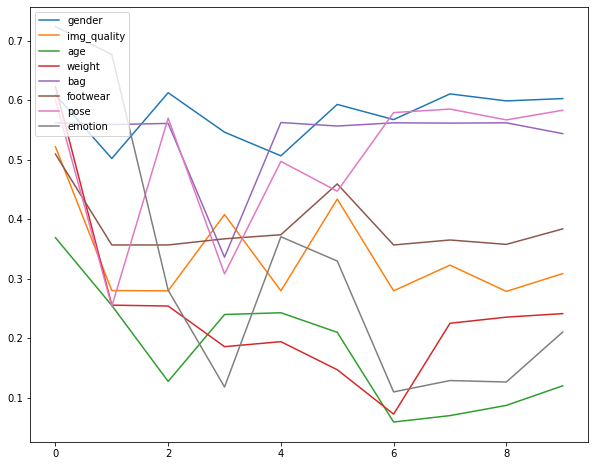

MessageError: ignored

In [0]:
from google.colab import files
plot_acc(history)
files.download('resnet18-10epochs.jpg')

In [0]:
model